<img align="left" src="https://github.com/GarethSequeira/Credit-Card-Fraud-Analysis/blob/main/CreditCardFraudAnalysis/Images/CreditCardRect.png?raw=true" width="100%">  

<br>  

# Credit Card Fraud Detection

#### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import calibration_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer,f1_score,r2_score
from sklearn.preprocessing import binarize, PolynomialFeatures
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.metrics import roc_auc_score, log_loss, accuracy_score,roc_curve


import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import warnings
from sklearn.metrics import mean_squared_error
warnings.filterwarnings('ignore')

%matplotlib inline

#### Define Functions to be Used

In [2]:
# Define Function to Print Accuracy Metrics

def print_accuracy_metrics(Input,Output):
  print("Recall:", recall_score(Input, Output))
  print("Log Loss:", log_loss(Input, Output))
  print("Precision:", precision_score(Input, Output))
  print("Accuracy:", accuracy_score(Input, Output))
  print("AUC: ", roc_auc_score(Input, Output))
  print("F1 Score:", f1_score(Input, Output))
  confusion_matrix_value = confusion_matrix(Input,Output)
  print('Confusion matrix:\n', confusion_matrix_value)
  class_names=[0,1] # name  of classes
  fig, ax = plt.subplots()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names)
  plt.yticks(tick_marks, class_names)
  # create heatmap
  sns.heatmap(pd.DataFrame( confusion_matrix_value), annot=True, cmap="YlGnBu" ,fmt='g')
  ax.xaxis.set_label_position("top")
  plt.tight_layout()
  plt.title('Confusion matrix', y=1.1)
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

In [3]:
# Defined Function to Print Cross Validation Score

scoring = {'recall' : make_scorer(recall_score)}

def cross_validation_metrics(log_reg, X, y):
 log_reg_score = cross_val_score(log_reg, X,y,cv=5,scoring='recall')
 print('Logistic Regression Cross Validation Score(Recall): ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')

In [4]:
# Function for Plotting Feature Importance
def feature_importance(model, X):
  importances = model.feature_importances_
  std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

def feature_importance(model, X):
  importances = model.feature_importances_
  std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
  indices = np.argsort(importances)[::-1]


  # Print the Feature Ranking
  print("Feature Ranking:")

  for f in range(X.shape[1]):
      print("%d. %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))

    
  # Plot Feature Importances of the Forest
  plt.figure()
  plt.title("Feature Importance")
  plt.bar(range(X.shape[1]), importances[indices],
          color="r", yerr=std[indices], align="center")
  plt.xticks(range(X.shape[1]), indices)
  plt.xlim([-1, X.shape[1]])
  plt.show()
  indices = np.argsort(importances)[::-1]

    
  # Print the Feature Ranking
  print("Feature Ranking:")

  for f in range(X.shape[1]):
      print("%d. %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))

        
  # Plot Feature Importances of the forest
  plt.figure()
  plt.title("Feature Importance")
  plt.bar(range(X.shape[1]), importances[indices],
          color="r", yerr=std[indices], align="center")
  plt.xticks(range(X.shape[1]), indices)
  plt.xlim([-1, X.shape[1]])
  plt.show()

In [5]:
# Function to Draw ROC curve
def plot_auc_curve(model,):
  auc = roc_auc_score(y, y_pred_prob)
  fpr, tpr, thresholds = roc_curve(y, y_pred_prob)
  
  plt.plot(fpr, tpr)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.title('ROC Curve \n AUC={auc}'.format(auc = auc))
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.grid(True)

In [6]:
# Read Data as a Pandas Dataframe

data = pd.read_csv('CreditCard.csv')

<br>  
  
#### Data Exploration and Cleaning

In [7]:
#Exploring data set
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [8]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


#### Observations

In [9]:
data.shape

(284807, 31)

In [10]:
data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [11]:
# Checking for Null Values in Dataset

data.isnull().sum().max()

0

There are no null values in dataset 

#### Data is nearly Clean.
Let us now Plot Histograms for Each Column

#### Data Visualization

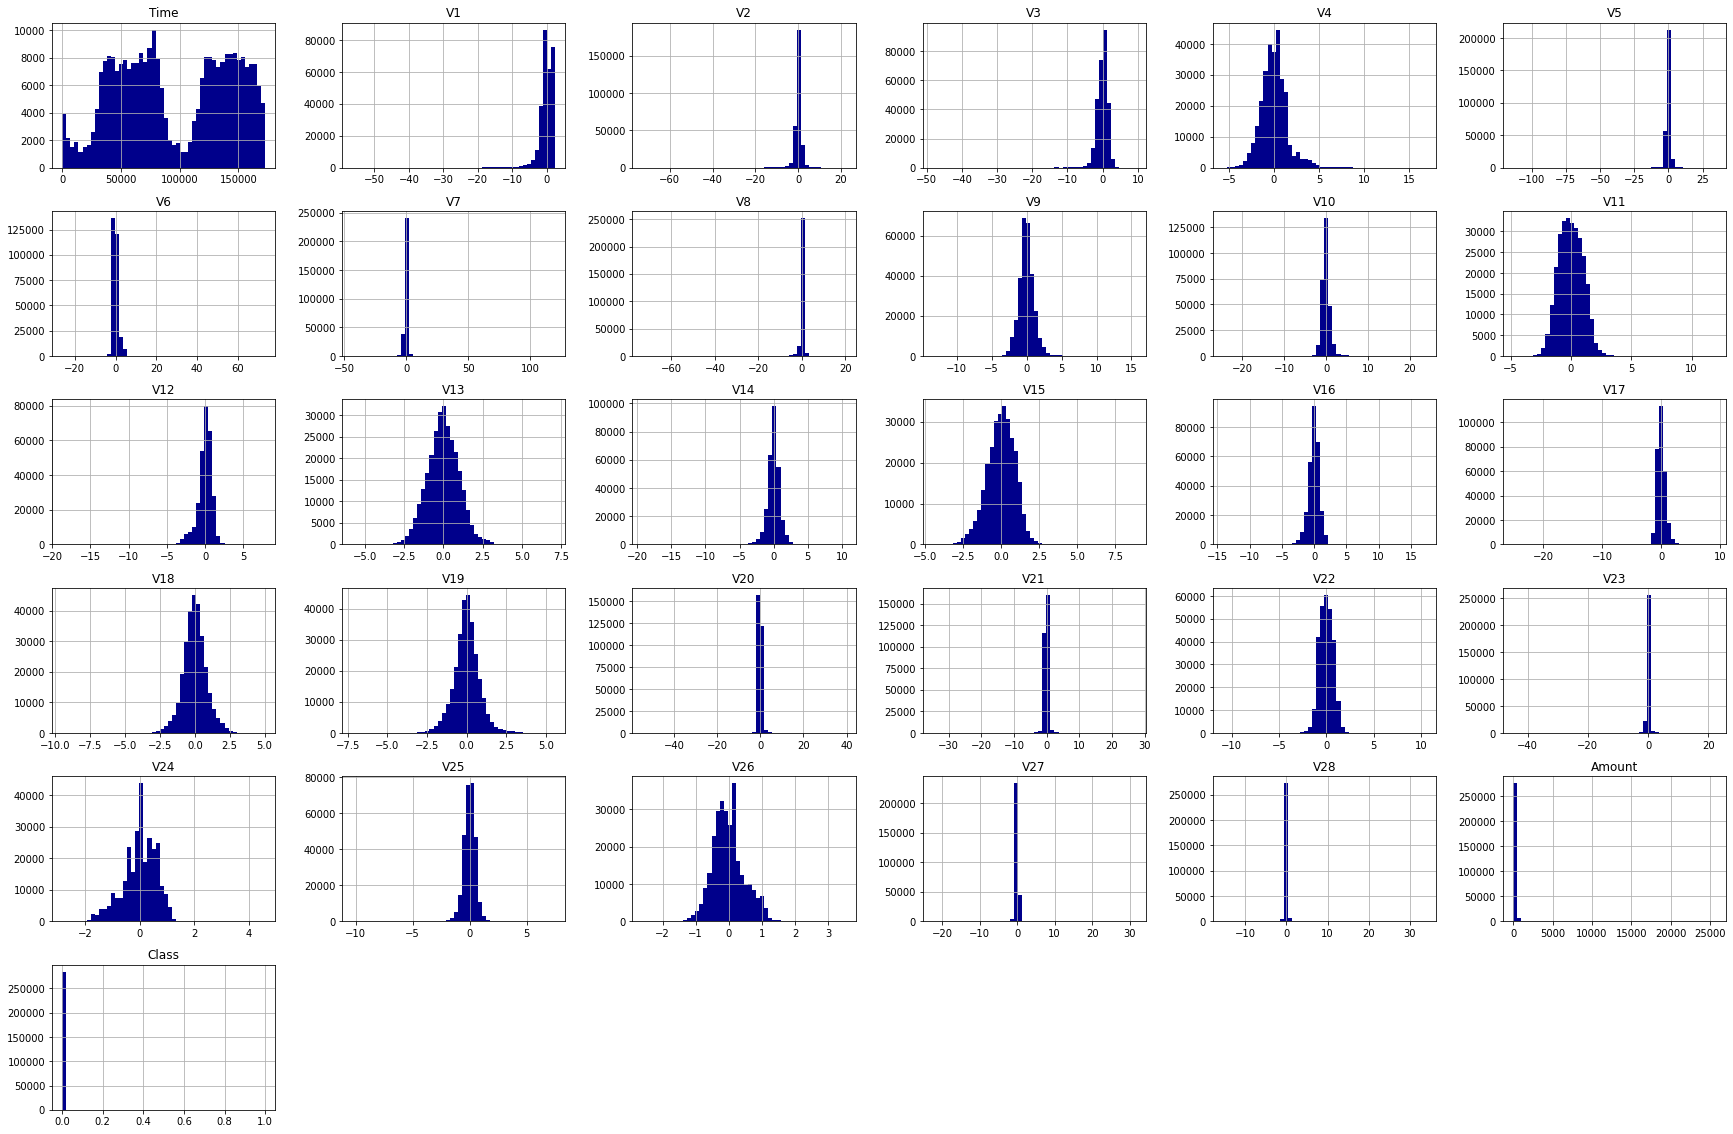

In [12]:
# Plot Histograms for Each 

data.hist(bins=50, figsize=(30,20), color="darkblue")
plt.show()

We can observe that all the features in dataset are scaled except Amount and Time.
<br><br>
#### Let us now scale *Amount* and delete *Time* column from the Dataset

In [13]:
data['normal_amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1,1))
data = data.drop(['Amount','Time'], axis=1)

X = data.loc[:,data.columns != 'Class']
y = data.loc[:,data.columns == 'Class']

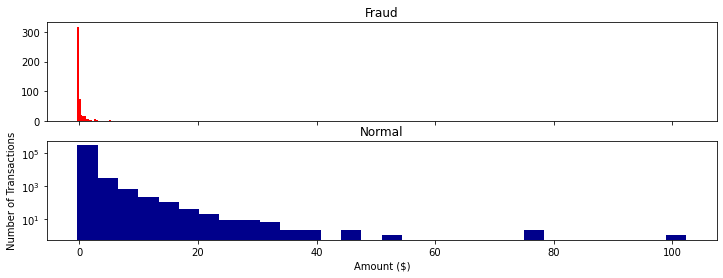

In [14]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))
bins = 30

ax1.hist(data.normal_amount[data.Class == 1], bins = bins, color="red")
ax1.set_title('Fraud')

ax2.hist(data.normal_amount[data.Class == 0], bins = bins, color="darkblue")
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.yscale('log')
plt.show()

We can observe from the above plot that the Fraud transactions are very less
#### Let us now visualize number of Fraud transactions and number of Non-Fraud transactions side by side

Text(0, 0.5, 'Frequency')

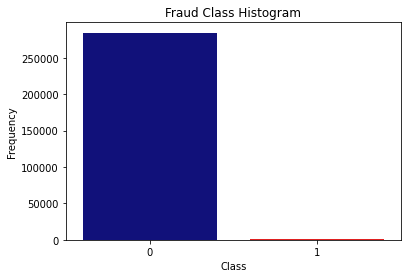

In [15]:
# Now Lets Check the Class Distribution

sns.countplot("Class", data=data, palette=["darkblue", "red"])
    
plt.title("Fraud Class Histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")

We can observe from the plot that there are many Legitimate(Non-Fraud/0) as compared to Fraud(1) Transactions 
#### This kind of Imbalance in the target variable is known as Class Imbalance

In [16]:
# Showing Ratio

print("Percentage of normal transactions: ", len(data[data.Class == 0])/len(data))
print("Percentage of fraud transactions: ", len(data[data.Class == 1])/len(data))
print("Total number of transactions in data: ", len(data))

Percentage of normal transactions:  0.9982725143693799
Percentage of fraud transactions:  0.001727485630620034
Total number of transactions in data:  284807


Most of the Transactions were Non-Fraud 99.83% of the Time <br>
While Fraud transactions occurs 0.17% of the Time in the Data

#### Splitting original dataset into Test and Train

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 0)

## We can now perform Logistic Regression on this Split Data
### • Logistic Regression on Imbalanced Dataset

In [18]:
lr = LogisticRegression()
lr.fit(X_train,y_train)

LogisticRegression()

Logistic Regression Cross Validation Score(Recall):  61.74%
Recall: 0.6190476190476191
Log Loss: 0.02748787367043729
Precision: 0.883495145631068
Accuracy: 0.999204147794436
AUC:  0.8094534662486266
F1 Score: 0.728
Confusion matrix:
 [[85284    12]
 [   56    91]]


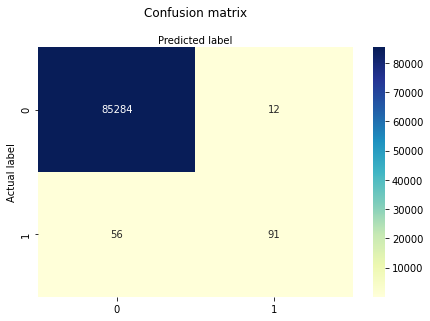

In [19]:
# Accuracy Metrics

y_pred = lr.predict(X_test)
cross_validation_metrics(lr,X_train,y_train)
print_accuracy_metrics(y_test,y_pred)

#### Observations:
By observing the accuracy we can conclude that algorithm is performing extremely well . But it’s not true. As most of the labels 0, even random a guess will give you 99% accuracy. Hence, a better measure is needed to understand the performance of the model. 

#### Recall
Recall is a measure which measures the ability of model to predict right for a given label. In our case, we want to test the model how accurately it can recall fraud cases as we are interested in that.
As you can observe from the results, the recall for 1.0 is only 0.6016 compared to 99% for 0. So our model is not doing a good job of recognising frauds. So this depicts how imbalanced data is effecting accuracy of our model.

### •  Logistic Regression using Class Weight

Scikit-learn Logistic Regression has a option named class_weight when specified does class imbalance handling implicitly. <br> Hence, we try to predict using this technique

In [20]:
lr_balanced = LogisticRegression(class_weight = 'balanced')
lr_balanced.fit(X_train,y_train)

LogisticRegression(class_weight='balanced')

Logistic Regression Cross Validation Score(Recall):  89.86%
Recall: 0.9115646258503401
Log Loss: 0.7886743485866663
Precision: 0.06467181467181467
Accuracy: 0.9771660639256581
AUC:  0.9444218739831329
F1 Score: 0.12077512392969804
Confusion matrix:
 [[83358  1938]
 [   13   134]]


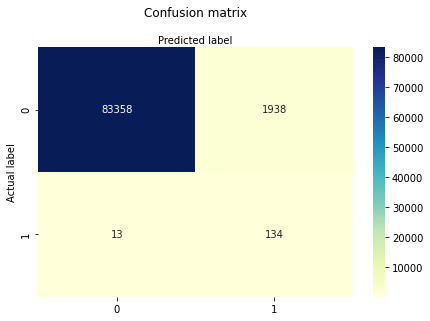

In [21]:
y_balanced_pred = lr_balanced.predict(X_test)
cross_validation_metrics(lr_balanced,X_train,y_train)
print_accuracy_metrics(y_test,y_balanced_pred)

In [22]:
y_balanced_pred_prob = lr_balanced.predict_proba(X_test)[:, 1]

In [23]:
print('Prob:', y_balanced_pred_prob[0:20])

Prob: [0.11787737 0.10846437 0.16225886 0.04103306 0.06945814 0.80536086
 0.33631759 0.01522809 0.01659318 0.45299479 0.03836546 0.02968987
 0.0013642  0.00311836 0.00773784 0.05655792 0.01762419 0.00896546
 0.09345336 0.0514922 ]


In [24]:
print('Prob:', y_balanced_pred[0:20])

Prob: [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


#### Undersampling of the dataset
Undersampling is one of the techniques used for handling class imbalance.  
In this technique, we under sample majority class to match the minority class.  
So in our example, we take random sample of non-fraud class to match number of fraud samples.   
This makes sure that the training data has equal amount of fraud and non-fraud samples.  

In [25]:
number_records_fraud = len(data[data.Class == 1])
fraud_indices = np.array(data[data.Class == 1].index)

In [26]:
normal_indices = data[data.Class == 0].index

In [27]:
random_normal_indices = np.random.choice(normal_indices, number_records_fraud, replace = False)
random_normal_indices = np.array(random_normal_indices)

In [28]:
under_sample_indices = np.concatenate([fraud_indices,random_normal_indices])

In [29]:
under_sample = data.iloc[under_sample_indices,:]

In [30]:
under_sample.shape

(984, 30)

This shows 984 total observations in our undersampled dataframe.
#### Visualising Undersampled Data

Text(0, 0.5, 'Frequency')

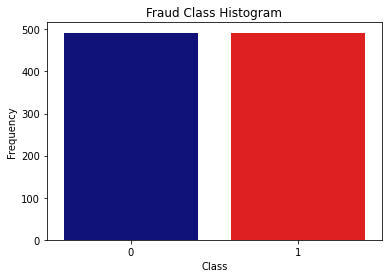

In [31]:
# Now lets Class Distributions

sns.countplot("Class",data=under_sample, palette=["darkblue", "red"])
    
plt.title("Fraud Class Histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")

 We can observe that these (Non-Fraud [0] / [1] Fraud) classes are distributed evenly now.

If we try to correlate class and features on imbalanced dataset then it will be of no use as we will not see true correlations of these features with the result.  
Let us now see the features and their correlations w.r.t class on undersampled dataframe.

<AxesSubplot:>

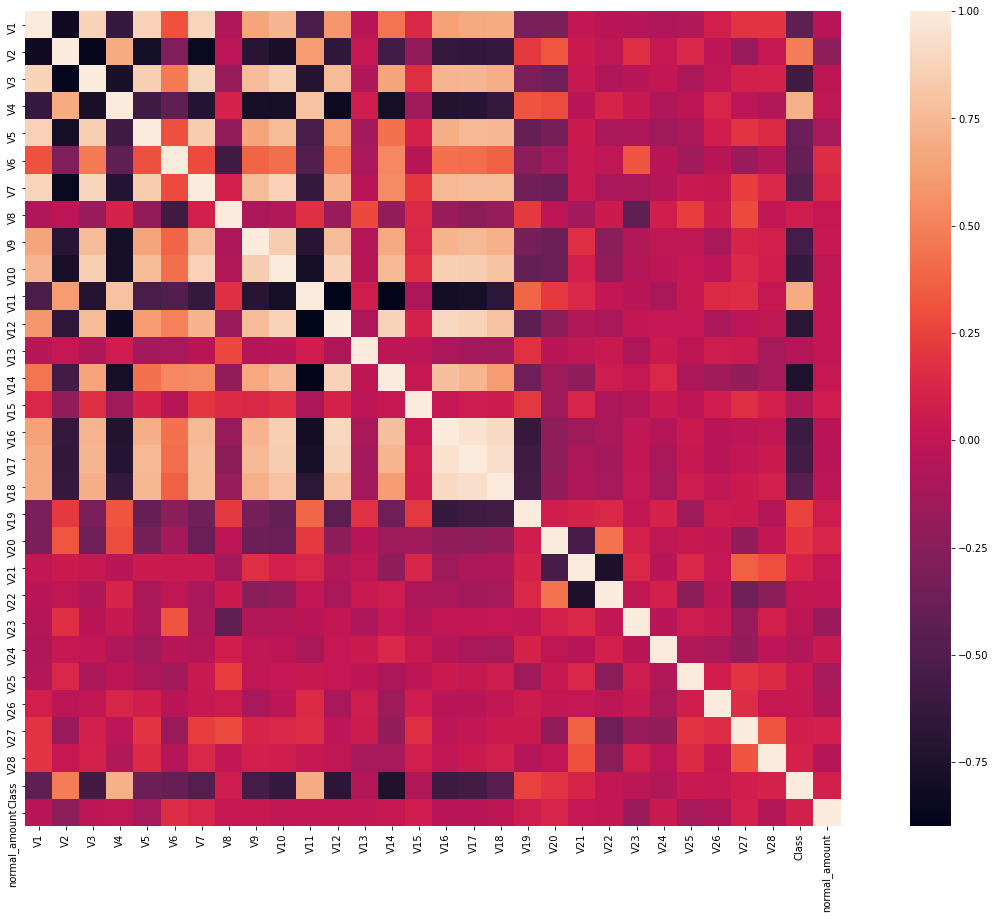

In [32]:
# Correlation Matrix

corrmat =under_sample.corr()
fig,ax= plt.subplots()
fig.set_size_inches(25,15)
sns.heatmap(corrmat,square=True)

In [33]:
# Partition the Data into Train and Test Sets

X_under_train, X_under_test, y_under_train, y_under_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

rf = RandomForestClassifier(n_estimators=100, criterion='gini', max_features='sqrt', n_jobs=-1)
rf.fit(X_under_train, y_under_train)

RandomForestClassifier(max_features='sqrt', n_jobs=-1)

Feature Ranking:
1. V17 (0.147417)
2. V12 (0.131724)
3. V14 (0.128517)
4. V11 (0.091938)
5. V16 (0.068286)
6. V10 (0.065863)
7. V18 (0.033258)
8. V9 (0.033127)
9. V7 (0.025072)
10. V26 (0.024775)
11. V21 (0.024545)
12. V4 (0.022969)
13. V3 (0.017357)
14. V6 (0.016154)
15. V8 (0.013948)
16. V5 (0.013632)
17. V20 (0.013449)
18. V15 (0.013355)
19. V27 (0.013186)
20. V1 (0.012899)
21. normal_amount (0.011582)
22. V19 (0.011543)
23. V13 (0.010827)
24. V22 (0.010590)
25. V2 (0.009815)
26. V28 (0.009363)
27. V24 (0.008956)
28. V25 (0.008431)
29. V23 (0.007424)


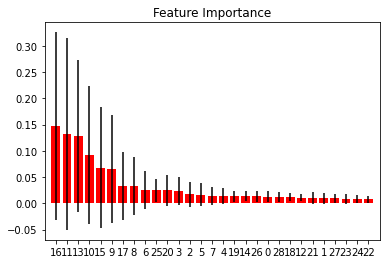

Feature Ranking:
1. V17 (0.147417)
2. V12 (0.131724)
3. V14 (0.128517)
4. V11 (0.091938)
5. V16 (0.068286)
6. V10 (0.065863)
7. V18 (0.033258)
8. V9 (0.033127)
9. V7 (0.025072)
10. V26 (0.024775)
11. V21 (0.024545)
12. V4 (0.022969)
13. V3 (0.017357)
14. V6 (0.016154)
15. V8 (0.013948)
16. V5 (0.013632)
17. V20 (0.013449)
18. V15 (0.013355)
19. V27 (0.013186)
20. V1 (0.012899)
21. normal_amount (0.011582)
22. V19 (0.011543)
23. V13 (0.010827)
24. V22 (0.010590)
25. V2 (0.009815)
26. V28 (0.009363)
27. V24 (0.008956)
28. V25 (0.008431)
29. V23 (0.007424)


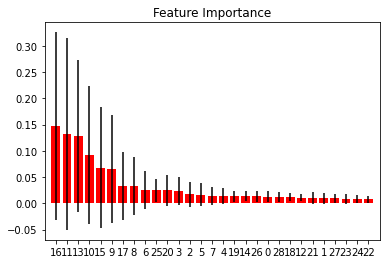

In [34]:
feature_importance(rf,X_under_train)

From the above heeatmap we can say that many of features are correlated but we are more interested in correlation of features with class. Hence ley us list those features whose correlation coefficient w.r.t class is less than -0.6 or greater than 0.6

In [35]:
# Negative Correlations Less than -0.5

corr = under_sample.corr()
corr = corr[['Class']]
corr[corr.Class < -0.6]

,Class
V10,-0.629645
V12,-0.679469
V14,-0.748939


In [36]:
# Positive Correlations Greater than 0.5

corr[corr.Class > 0.6]

,Class
V4,0.708329
V11,0.684984
Class,1.000000


#### Box Plots
We will use boxplots to have a better understanding of the distribution of these features in fradulent and non-fradulent transactions.

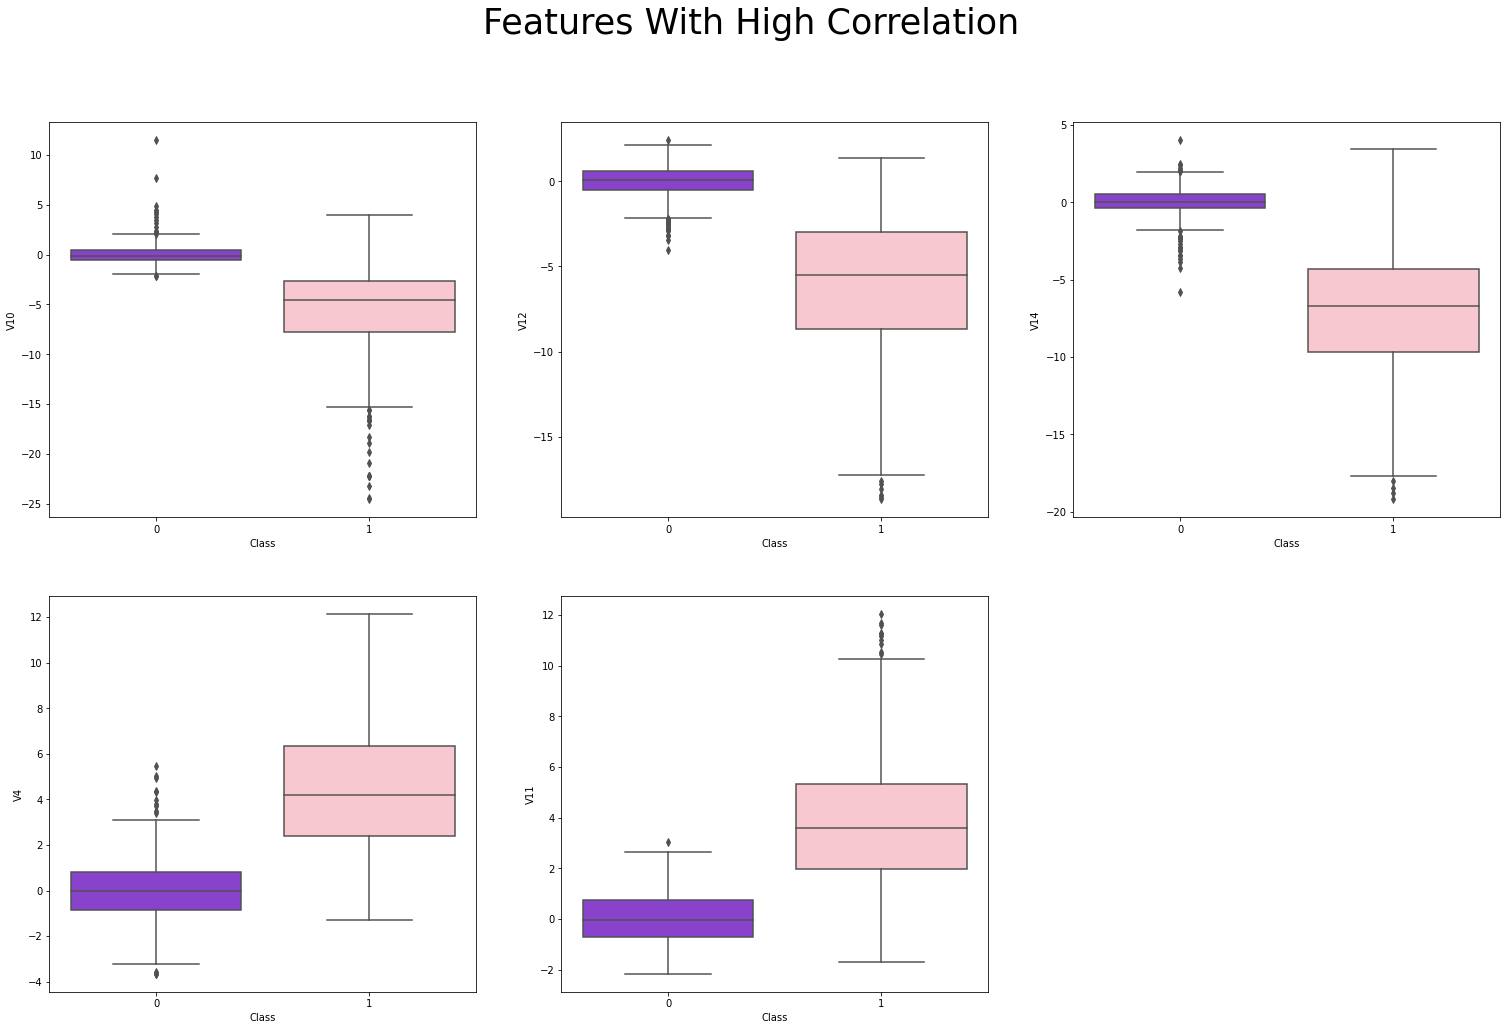

In [37]:
# Visualizing Features with High Correlation

f, axes = plt.subplots(nrows=2, ncols=3, figsize=(26,16))
f.suptitle('Features With High Correlation', size=35)
sns.boxplot(x="Class", y="V10", data=under_sample, ax=axes[0,0], palette=["blueviolet", "pink"])
sns.boxplot(x="Class", y="V12", data=under_sample, ax=axes[0,1], palette=["blueviolet", "pink"])
sns.boxplot(x="Class", y="V14", data=under_sample, ax=axes[0,2], palette=["blueviolet", "pink"])
sns.boxplot(x="Class", y="V4", data=under_sample, ax=axes[1,0], palette=["blueviolet", "pink"])
sns.boxplot(x="Class", y="V11", data=under_sample, ax=axes[1,1], palette=["blueviolet", "pink"])
f.delaxes(axes[1,2])

Box plots provide us with a good intuition of whether we need to worry about outliers as all transactions outside of 1.5 times the IQR (Inter-Quartile Range) are usually considered to be outliers. However, removing all transactions outside of 1.5 times the IQR would dramatically decrease  training data size, which is not very large, to begin with. Hence, we only focus on extreme outliers outside of 2.5 times the IQR.

In [38]:
under_sample.shape

(984, 30)

#### Removing Extreme Outliers

In [39]:
v14_fraud = under_sample['V14'].loc[under_sample['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
v14_iqr = q75 - q25
v14_cut_off = v14_iqr * 2.5
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
under_sample= under_sample.drop(under_sample[(under_sample['V14'] > v14_upper) | (under_sample['V14'] < v14_lower)].index)


In [40]:
v12_fraud = under_sample['V12'].loc[under_sample['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
v12_iqr = q75 - q25
v12_cut_off = v12_iqr * 2.5
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
under_sample= under_sample.drop(under_sample[(under_sample['V12'] > v12_upper) | (under_sample['V12'] < v12_lower)].index)


In [41]:
v10_fraud = under_sample['V10'].loc[under_sample['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
v10_iqr = q75 - q25
v10_cut_off = v10_iqr * 2.5
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
under_sample= under_sample.drop(under_sample[(under_sample['V10'] > v10_upper) | (under_sample['V10'] < v10_lower)].index)


In [42]:
v4_fraud = under_sample['V4'].loc[under_sample['Class'] == 1].values
q25, q75 = np.percentile(v4_fraud, 25), np.percentile(v4_fraud, 75)
v4_iqr = q75 - q25
v4_cut_off = v4_iqr * 2.5
v4_lower, v4_upper = q25 - v4_cut_off, q75 + v4_cut_off
under_sample= under_sample.drop(under_sample[(under_sample['V4'] > v4_upper) | (under_sample['V4'] < v4_lower)].index)

In [43]:
v11_fraud = under_sample['V11'].loc[under_sample['Class'] == 1].values
q25, q75 = np.percentile(v11_fraud, 25), np.percentile(v11_fraud, 75)
v11_iqr = q75 - q25
v11_cut_off = v11_iqr * 2.5
v11_lower, v11_upper = q25 - v11_cut_off, q75 + v11_cut_off
under_sample= under_sample.drop(under_sample[(under_sample['V11'] > v11_upper) | (under_sample['V11'] < v11_lower)].index)

In [44]:
under_sample.shape

(975, 30)

#### After removing outliers our undersample Dataframe is reduced 

#### Splitting under sampled Dataframe

In [45]:
X_under = under_sample.loc[:,under_sample.columns != 'Class']
y_under = under_sample.loc[:,under_sample.columns == 'Class']
X_under_train, X_under_test, y_under_train, y_under_test = train_test_split(X_under,y_under,test_size = 0.3, random_state = 0)

### • Logistic regression with C=0.01

In [46]:
lr_under_C1 = LogisticRegression(C=0.01, penalty='l1', solver='liblinear')
lr_under_C1.fit(X_under_train,y_under_train)

LogisticRegression(C=0.01, penalty='l1', solver='liblinear')

Logistic Regression Cross Validation Score(Recall):  95.93%
Recall: 0.9183673469387755
Log Loss: 4.4228022346714475
Precision: 0.01220173535791757
Accuracy: 0.8719497208665427
AUC:  0.8951185355965683
F1 Score: 0.024083489430024085
Confusion matrix:
 [[74367 10929]
 [   12   135]]


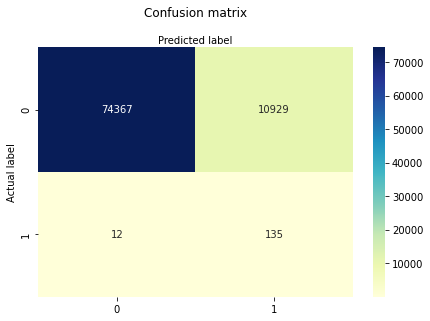

In [47]:
# Prediction on Original Dataframe

y_pred_full_model1 = lr_under_C1.predict(X_test)
cross_validation_metrics(lr_under_C1,X_under_train,y_under_train)
print_accuracy_metrics(y_test,y_pred_full_model1)

### • Logistic Regression with C=0.1

In [48]:
lr_under_C2 = LogisticRegression(C=0.1, penalty='l1', solver='liblinear')
lr_under_C2.fit(X_under_train,y_under_train)

LogisticRegression(C=0.1, penalty='l1', solver='liblinear')

Logistic Regression Cross Validation Score(Recall):  89.23%
Recall: 0.9115646258503401
Log Loss: 0.6484026719210262
Precision: 0.07768115942028986
Accuracy: 0.9812272509158152
AUC:  0.9464559670238382
F1 Score: 0.14316239316239315
Confusion matrix:
 [[83705  1591]
 [   13   134]]


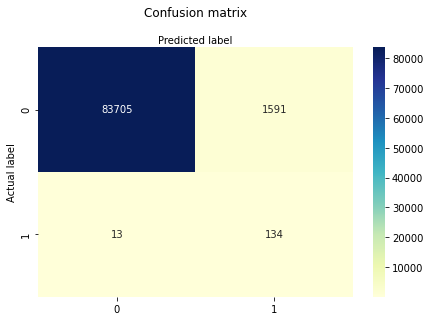

In [49]:
# Prediction on Original Dataset

y_pred_full_model2 = lr_under_C2.predict(X_test)
cross_validation_metrics(lr_under_C2,X_under_train,y_under_train)
print_accuracy_metrics(y_test,y_pred_full_model2)

### • Logistic Regression with C=1

In [50]:
lr_under_C3 = LogisticRegression(C=1, penalty='l1', solver='liblinear')
lr_under_C3.fit(X_under_train,y_under_train)

LogisticRegression(C=1, penalty='l1', solver='liblinear')

Logistic Regression Cross Validation Score(Recall):  89.82%
Recall: 0.9251700680272109
Log Loss: 1.0061561023063887
Precision: 0.05202754399387911
Accuracy: 0.9708694685345786
AUC:  0.9480591476883382
F1 Score: 0.09851503078594713
Confusion matrix:
 [[82818  2478]
 [   11   136]]


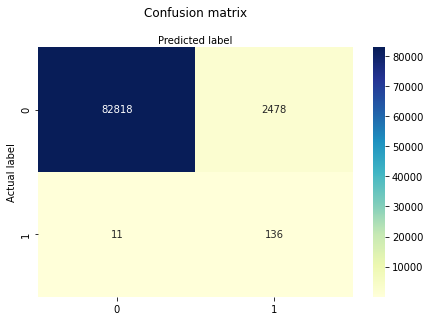

In [51]:
# Prediction on Original Dataset

y_pred_full_model3 = lr_under_C3.predict(X_test)
cross_validation_metrics(lr_under_C3,X_under_train,y_under_train)
print_accuracy_metrics(y_test,y_pred_full_model3)

### • Logistic Regreesion with C=10

In [52]:
lr_under_C4 = LogisticRegression(C=10, penalty='l1', solver='liblinear')
lr_under_C4.fit(X_under_train,y_under_train)

LogisticRegression(C=10, penalty='l1', solver='liblinear')

Logistic Regression Cross Validation Score(Recall):  90.69%
Recall: 0.9319727891156463
Log Loss: 1.1403641711833548
Precision: 0.04647218453188602
Accuracy: 0.9669838371780017
AUC:  0.9495084823462305
F1 Score: 0.08852988691437802
Confusion matrix:
 [[82485  2811]
 [   10   137]]


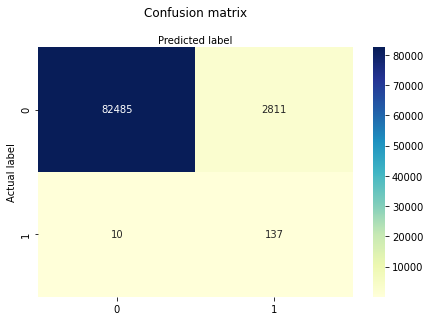

In [53]:
# Prediction on Original Dataset

y_pred_full_model4 = lr_under_C4.predict(X_test)
cross_validation_metrics(lr_under_C4,X_under_train,y_under_train)
print_accuracy_metrics(y_test,y_pred_full_model4)

## Decision Tree Classifier

In [54]:
DecisionTreeClassifier= DecisionTreeClassifier()
DecisionTreeClassifier.fit(X_under_train,y_under_train)

DecisionTreeClassifier()

Logistic Regression Cross Validation Score(Recall):  90.1%
Recall: 0.9591836734693877
Log Loss: 2.614227416463419
Precision: 0.021357164495607393
Accuracy: 0.9243121145090879
AUC:  0.9417178449883048
F1 Score: 0.041783967995258554
Confusion matrix:
 [[78835  6461]
 [    6   141]]


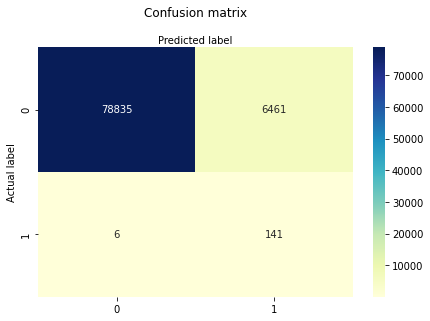

In [55]:
# Prediction on Original Dataset
y_pred_DecisionTree = DecisionTreeClassifier.predict(X_test)
cross_validation_metrics(DecisionTreeClassifier,X_under_train,y_under_train)
print_accuracy_metrics(y_test,y_pred_DecisionTree)

<br>  
  
## Plotting Final Comparison of Logistic Regression with Various Parameters

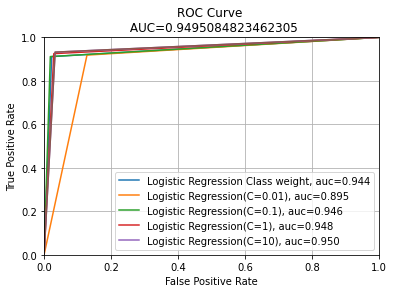

In [56]:
plt.figure(0).clf()

fpr, tpr, thresh = metrics.roc_curve(y_test, y_balanced_pred)
auc = metrics.roc_auc_score(y_test, y_balanced_pred)
plt.plot(fpr,tpr,label="Logistic Regression Class weight, auc="+ '{0:.3f}'.format(auc))

fpr, tpr, thresh = metrics.roc_curve(y_test, y_pred_full_model1)
auc = metrics.roc_auc_score(y_test, y_pred_full_model1)
plt.plot(fpr,tpr,label="Logistic Regression(C=0.01), auc="+ '{0:.3f}'.format(auc))

fpr, tpr, thresh = metrics.roc_curve(y_test, y_pred_full_model2)
auc = metrics.roc_auc_score(y_test, y_pred_full_model2)
plt.plot(fpr,tpr,label="Logistic Regression(C=0.1), auc="+'{0:.3f}'.format(auc))

fpr, tpr, thresh = metrics.roc_curve(y_test, y_pred_full_model3)
auc = metrics.roc_auc_score(y_test, y_pred_full_model3)
plt.plot(fpr,tpr,label="Logistic Regression(C=1), auc="+'{0:.3f}'.format(auc))

fpr, tpr, thresh = metrics.roc_curve(y_test, y_pred_full_model4)
auc = metrics.roc_auc_score(y_test, y_pred_full_model4)
plt.plot(fpr,tpr,label="Logistic Regression(C=10), auc="+'{0:.3f}'.format(auc))

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC Curve \n AUC={auc}'.format(auc = auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.legend(loc="lower right")

<br><br>  

Note: By trying to increase recall, the result decreases in precision. <br>
However, if we predict that a transaction is fraudulent and turns out not to be, is not a massive problem as compared to when it occurs vice versa.